In [1]:
import pandas as pd
import os
import glob
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score

pre_trained = "bert-base-german-cased"

### Hyperparameters


In [2]:
epochs = 40
batch_size = 20
drop_out = 0.3

# DataSet

In [3]:
dataset = pd.read_csv('/kaggle/input/discharge-letter/Discharge_letter_dataset.csv')  

In [4]:
possible_labels = dataset.Category.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'-': 0, 'MH': 1, 'D': 2, 'TP': 3, 'S': 4, 'DP': 5}

In [5]:
tokenizer = BertTokenizer.from_pretrained(pre_trained, 
                                          do_lower_case=True)
                                          
encoded_data_train = tokenizer.batch_encode_plus(
    dataset[dataset.data_type=='train'].Text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    dataset[dataset.data_type=='val'].Text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(dataset[dataset.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(dataset[dataset.data_type=='val'].label.values)


Downloading:   0%|          | 0.00/249k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Splitting dataset (Train, Test)

In [6]:

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [7]:
model = BertForSequenceClassification.from_pretrained(pre_trained,
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False,
                                                      attention_probs_dropout_prob = drop_out,
                                                      hidden_dropout_prob = drop_out
)
model.cuda()

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoi

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.3, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

# Setting model parameters

In [8]:

OverAll_f1 = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

optimizer = AdamW(model.parameters(),lr=1e-5, eps=1e-8)


scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


# Accuracy metric


In [9]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    Accuracy = 0
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        #print(f'Class: {label_dict_inverse[label]}')
        #print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')
        Accuracy += len(y_preds[y_preds==label])/len(y_true)
    return (Accuracy/6)

# Training

In [10]:
import random

train_loss_dict = {}
val_loss_dict = {}
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'/kaggle/working/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    OverAll_f1.append((epoch,val_f1))
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    train_loss_dict[epoch] = loss_train_avg
    val_loss_dict[epoch] = val_loss


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.610048766275054
Validation loss: 1.3708433791210777
F1 Score (Weighted): 0.4202515285955061


Epoch 2:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.3097315384346304
Validation loss: 1.1226625505246615
F1 Score (Weighted): 0.5508334168483728


Epoch 3:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 3
Training loss: 1.150815960851688
Validation loss: 1.0045879294997768
F1 Score (Weighted): 0.5968840003033489


Epoch 4:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 4
Training loss: 1.0052675726344285
Validation loss: 0.9789264233488786
F1 Score (Weighted): 0.6180249858862119


Epoch 5:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.9255954605861775
Validation loss: 0.9021794513652199
F1 Score (Weighted): 0.6632197205725187


Epoch 6:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.806075398783082
Validation loss: 0.8830904301844145
F1 Score (Weighted): 0.6894090872954695


Epoch 7:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.7552060126100929
Validation loss: 0.8717985561019496
F1 Score (Weighted): 0.6893792083864597


Epoch 8:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.6851506638295443
Validation loss: 0.8411025624526175
F1 Score (Weighted): 0.6967554105828668


Epoch 9:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.6386624152220569
Validation loss: 0.877956106474525
F1 Score (Weighted): 0.7066697279361791


Epoch 10:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.5980626631130292
Validation loss: 0.8892296772254141
F1 Score (Weighted): 0.6941258104805237


Epoch 11:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.5413575487808117
Validation loss: 0.8368195326704728
F1 Score (Weighted): 0.7351101819906295


Epoch 12:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.5119173943417744
Validation loss: 0.8395938245873702
F1 Score (Weighted): 0.7419758251639759


Epoch 13:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.4433590069557857
Validation loss: 0.9070056574909311
F1 Score (Weighted): 0.7314065746261512


Epoch 14:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.4227055966564753
Validation loss: 0.9028160956345106
F1 Score (Weighted): 0.7404946274114005


Epoch 15:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 15
Training loss: 0.41808333515542223
Validation loss: 0.9217273083172346
F1 Score (Weighted): 0.7338355656303335


Epoch 16:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 16
Training loss: 0.3749746890033333
Validation loss: 0.8909717690395681
F1 Score (Weighted): 0.7369504843674793


Epoch 17:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 17
Training loss: 0.3543447626447215
Validation loss: 0.9581930409920844
F1 Score (Weighted): 0.7345656683121444


Epoch 18:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 18
Training loss: 0.33546095160604683
Validation loss: 0.9663678590012225
F1 Score (Weighted): 0.7459045019633681


Epoch 19:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 19
Training loss: 0.3228039368625405
Validation loss: 0.9608693024829814
F1 Score (Weighted): 0.7410273808868382


Epoch 20:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 20
Training loss: 0.295624734996592
Validation loss: 0.9721369402189004
F1 Score (Weighted): 0.73933219915859


Epoch 21:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 21
Training loss: 0.28383763546793206
Validation loss: 1.063114226452614
F1 Score (Weighted): 0.7297122553124269


Epoch 22:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 22
Training loss: 0.26966148097682924
Validation loss: 1.1128488749657806
F1 Score (Weighted): 0.7184301569837427


Epoch 23:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 23
Training loss: 0.2584262354643021
Validation loss: 1.0521741658449173
F1 Score (Weighted): 0.7323558715880145


Epoch 24:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 24
Training loss: 0.2538012963837212
Validation loss: 1.0993698521664268
F1 Score (Weighted): 0.7371186210965216


Epoch 25:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 25
Training loss: 0.23853985202109929
Validation loss: 1.054480399348234
F1 Score (Weighted): 0.7524183258268604


Epoch 26:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 26
Training loss: 0.2269394296465568
Validation loss: 1.1072762569314556
F1 Score (Weighted): 0.7328232782526812


Epoch 27:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 27
Training loss: 0.20938090779321286
Validation loss: 1.1059237824458825
F1 Score (Weighted): 0.7406561701542178


Epoch 28:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 28
Training loss: 0.19099493735261913
Validation loss: 1.1538435883427922
F1 Score (Weighted): 0.7405838222029582


Epoch 29:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 29
Training loss: 0.20651019672022283
Validation loss: 1.163905233536896
F1 Score (Weighted): 0.7413809195872848


Epoch 30:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 30
Training loss: 0.20007570523732496
Validation loss: 1.2107455691224651
F1 Score (Weighted): 0.722101669585588


Epoch 31:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 31
Training loss: 0.1941902035919642
Validation loss: 1.1792447487578581
F1 Score (Weighted): 0.7425428998020451


Epoch 32:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 32
Training loss: 0.19588079842404255
Validation loss: 1.2061976017920595
F1 Score (Weighted): 0.7378029287592488


Epoch 33:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 33
Training loss: 0.17286514655406615
Validation loss: 1.2091208347364475
F1 Score (Weighted): 0.7498904558463673


Epoch 34:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 34
Training loss: 0.17184240335725176
Validation loss: 1.214306589019926
F1 Score (Weighted): 0.7380536276734253


Epoch 35:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 35
Training loss: 0.1683331628881612
Validation loss: 1.215998253539989
F1 Score (Weighted): 0.7439922376297353


Epoch 36:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 36
Training loss: 0.15822390115195975
Validation loss: 1.2434127432735342
F1 Score (Weighted): 0.7412332175708738


Epoch 37:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 37
Training loss: 0.1514724192652598
Validation loss: 1.2606021701113175
F1 Score (Weighted): 0.7382081116728397


Epoch 38:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 38
Training loss: 0.14831807128904226
Validation loss: 1.2550824031625922
F1 Score (Weighted): 0.7412332175708738


Epoch 39:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 39
Training loss: 0.16252938492531047
Validation loss: 1.2363267980123822
F1 Score (Weighted): 0.743616592478886


Epoch 40:   0%|          | 0/103 [00:00<?, ?it/s]


Epoch 40
Training loss: 0.14604943088319117
Validation loss: 1.2447858370448415
F1 Score (Weighted): 0.7376363232978737


# Testing best model

In [11]:
print(OverAll_f1)
model = BertForSequenceClassification.from_pretrained(pre_trained,
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.cuda()
total_acc = []
for i in range(epochs):
    model.load_state_dict(torch.load(f'/kaggle/working/finetuned_BERT_epoch_{i+1}.model', map_location=torch.device('cuda')))

    _, predictions, true_vals = evaluate(dataloader_validation)
    accuracy = accuracy_per_class(predictions, true_vals)
    total_acc.append((accuracy, i+1))
print(total_acc)

[(1, 0.4202515285955061), (2, 0.5508334168483728), (3, 0.5968840003033489), (4, 0.6180249858862119), (5, 0.6632197205725187), (6, 0.6894090872954695), (7, 0.6893792083864597), (8, 0.6967554105828668), (9, 0.7066697279361791), (10, 0.6941258104805237), (11, 0.7351101819906295), (12, 0.7419758251639759), (13, 0.7314065746261512), (14, 0.7404946274114005), (15, 0.7338355656303335), (16, 0.7369504843674793), (17, 0.7345656683121444), (18, 0.7459045019633681), (19, 0.7410273808868382), (20, 0.73933219915859), (21, 0.7297122553124269), (22, 0.7184301569837427), (23, 0.7323558715880145), (24, 0.7371186210965216), (25, 0.7524183258268604), (26, 0.7328232782526812), (27, 0.7406561701542178), (28, 0.7405838222029582), (29, 0.7413809195872848), (30, 0.722101669585588), (31, 0.7425428998020451), (32, 0.7378029287592488), (33, 0.7498904558463673), (34, 0.7380536276734253), (35, 0.7439922376297353), (36, 0.7412332175708738), (37, 0.7382081116728397), (38, 0.7412332175708738), (39, 0.743616592478886)

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoi

[(0.35434246812944115, 1), (0.4837906423945542, 2), (0.5306342085456417, 3), (0.5969514619147743, 4), (0.6169023217117194, 5), (0.655492822488506, 6), (0.6523669789931416, 7), (0.6545493993694061, 8), (0.6741370888720608, 9), (0.6627909402864257, 10), (0.6951287320878858, 11), (0.7111135493168388, 12), (0.7023957352748575, 13), (0.7089138024879359, 14), (0.7054352832805164, 15), (0.7060778514360283, 16), (0.7058401806101222, 17), (0.7142467866197558, 18), (0.7093945086154599, 19), (0.7066776852089814, 20), (0.7006859395488346, 21), (0.6898696258240397, 22), (0.7060452263188092, 23), (0.7081428617116391, 24), (0.7188145062380564, 25), (0.7010057831051659, 26), (0.7090335873848445, 27), (0.7097832125722506, 28), (0.7113837100931524, 29), (0.6947116289779344, 30), (0.7104194167952554, 31), (0.7055607748584526, 32), (0.715692785501972, 33), (0.7025801546081673, 34), (0.7104356101680703, 35), (0.709987393990954, 36), (0.706957090960651, 37), (0.709987393990954, 38), (0.7096321794413659, 39)

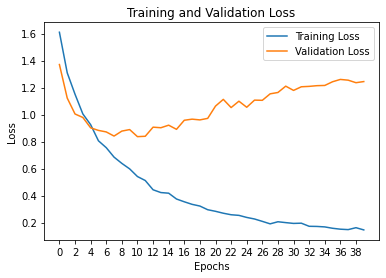

In [12]:
from matplotlib.pylab import plt
from numpy import arange


# Retrieve each dictionary's values
train_values = train_loss_dict.values()
val_values = val_loss_dict.values()

# Generate a sequence of integers to represent the epoch numbers
epochs_range = range(0, epochs)


# Plot and label the training and validation loss values
plt.plot(epochs_range, train_values, label='Training Loss')
plt.plot(epochs_range, val_values, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(arange(0, epochs, 2))

# Display the plot
plt.legend(loc='best')
plt.show()